<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep convolutional net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an IPython notebook via Learning Suite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracies
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import seaborn as sns

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset (Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
  def __getitem__(self, i):
    x, y = self.data[i]

    # pdb.set_trace()

    return x, y

  def __len__(self):
    return len(self.data)

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropyLoss function. Do not use PyTorch's implementation of cross entropy loss (F.cross_entropy or nn.CrossEntropyLoss) for your re-implementation of cross entropy loss. You may use PyTorch's functional implemenation of 2D convolution in your Conv2D module.

**TODO:** 

**DONE:**

* CrossEntropyLoss
* Conv2D

___

### Part 2
Implement three initialization strategies: Xe initialization
(sometimes called Xavier), orthogonal initialization, and uniform random initialization.
You can specify which strategy you want to use with a parameter.



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**



In [ ]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
    self.__dict__.update(locals())
    super(CrossEntropyLoss, self).__init__()

  def forward(self, input, target):

    losses = -input[torch.arange(input.size()[0]), target] + \
      torch.logsumexp((input), 1)
    return losses.mean()

class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1,
               padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros',
               device=None, dtype=None,
               w_init_method='uniform'):
    # in channels is depth of kernels
    # out channels is the number of kernels that you have
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()

    self.weight = Parameter(torch.Tensor(self.out_channels, 
                                         self.in_channels,
                                         *self.kernel_size))
    self.bias = Parameter(torch.Tensor(self.out_channels))

    # Initialize weights
    # uniform method
    if self.w_init_method == 'uniform':
      torch.nn.init.uniform(self.weight, -0.2, 0.2)

    # Xavier method
    elif self.w_init_method == 'xe':
      var = 2 / (self.in_channels + self.out_channels)
      self.weight.data = torch.from_numpy(np.random.normal(0, np.sqrt(var), self.weight.data.shape)).float()

    # Orthogonal method
    elif self.w_init_method == 'orthogonal':
      X = np.random.random((self.out_channels, self.in_channels * self.kernel_size[0] * self.kernel_size[1]))
      if X.shape[0] < X.shape[1]:
        U, _, Vt = np.linalg.svd(np.transpose(X), full_matrices=False)
        W = U.reshape((self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1]))
      else:
        U, _, Vt = np.linalg.svd(X, full_matrices=False)
        W = Vt.reshape((self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1]))
      self.weight.data = torch.from_numpy(W).float()

    self.bias.data.uniform_(0,0)

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias,
                    self.stride, self.padding,
                    self.dilation, self.groups)


In [ ]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset, w_init_method='uniform'):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10

    self.net = nn.Sequential(
        Conv2d(c, 1, (3,3), padding=(1,1), w_init_method=w_init_method),
        nn.ReLU(),
        Conv2d(1, 5, (3,3), padding=(1,1), w_init_method=w_init_method),
        nn.ReLU(),
        Conv2d(5, 10, (3,3), padding=(1,1), w_init_method=w_init_method),
        nn.ReLU(),
        Conv2d(10, 20, (3,3), padding=(1,1), w_init_method=w_init_method),
        nn.ReLU(),
        Conv2d(20, 40, (3,3), padding=(1,1), w_init_method=w_init_method),
        nn.ReLU(),
        Conv2d(40, 80, (3,3), padding=(1,1), w_init_method=w_init_method),
        nn.ReLU(),
        Conv2d(80, 160, (3,3), padding=(1,1), w_init_method=w_init_method),
        nn.ReLU(),
        Conv2d(160, output, (28,28), padding=(0,0), w_init_method=w_init_method)
    )

  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)


In [ ]:
# Initialize Datasets
train_dataset = FashionMNISTProcessedDataset('fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('fashionmnist', train=False)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=42, 
                          pin_memory=True)
validation_loader = DataLoader(val_dataset, 
                               batch_size=42, 
                               pin_memory=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashionmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashionmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashionmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashionmnist/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def train_model(model, num_epochs, train_loader, optimizer, objective):
    losses = []
    validations = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(), y_truth.cuda()
        optimizer.zero_grad() # zero out the gradient
        y_hat = model(x) # make predictions
        loss = objective(y_hat, y_truth) # calculate loss
        loss.backward() # backpropogate loss to update weights
        losses.append(loss.item()) # keep track of batch loss
        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        train_accuracies.append(accuracy.item())
        optimizer.step()

        # track validation loss / accuracy after certain num of iterations
        if batch % 50 == 0:
          val_accuracy = np.mean( [( torch.softmax(model(x.cuda()), 1).argmax(1) == y.cuda() ).float().mean().item()
                                  for x, y in validation_loader] )
          val_accuracies.append((len(losses), val_accuracy))

          val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                         for x, y in validation_loader])
          validations.append((len(losses), val))

        loop.set_description('epoch:{} loss:{:.4f} train_accuracy:{:.3f} val_accuracy:{:.3f}'.format(epoch, loss.item(), accuracy, val_accuracy))
        loop.update(1)
      loop.close()

    return losses, validations, train_accuracies, val_accuracies


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiments with each initialization strategy. You should be able to exceed 85% accuracy on the validation set in at least one of the plotted experiments.

**TODO:**

**DONE:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time for each initialization strategy (w/ accurate graph title and axes lables)
* Plot experiment results with 85% or better validation accuracy
* Print out number of parameters in the model

In [ ]:
num_epochs=2
lr=1e-4

In [ ]:
# Go back up and try a few different networks and initialization strategies
model_uni = ConvNetwork(train_dataset, w_init_method='uniform')
model_uni = model_uni.cuda()
objective = CrossEntropyLoss()
optimizer = optim.Adam(model_uni.parameters(), lr=lr)

losses_uni, validations_uni, train_accuracies_uni, val_accuracies_uni = \
    train_model(model_uni, num_epochs, train_loader, optimizer, objective)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


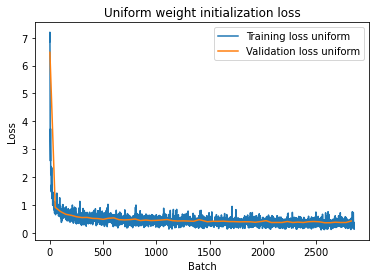

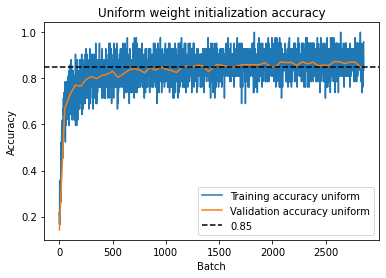

In [ ]:
# Plot training and validation loss for uniform initialization
a, b = zip(*validations_uni)
f1 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(losses_uni, label='Training loss uniform')
ax1.plot(a, b, label='Validation loss uniform')
plt.title('Uniform weight initialization loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy for uniform initialization
a, b = zip(*val_accuracies_uni)
f2 = plt.figure()
ax2 = f2.add_subplot(111)
ax2.plot(train_accuracies_uni, label='Training accuracy uniform')
ax2.plot(a, b, label='Validation accuracy uniform')
ax2.axhline(y=0.85, color='black', linestyle='dashed', label='0.85')
plt.title('Uniform weight initialization accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# # save the model
# torch.save(model_uni.state_dict(), 'models/model_uni.pt')

In [ ]:
# save the model

model_xe = ConvNetwork(train_dataset, w_init_method='xe')
model_xe = model_xe.cuda()
objective = CrossEntropyLoss()
optimizer = optim.Adam(model_xe.parameters(), lr=lr)

losses_xe, validations_xe, train_accuracies_xe, val_accuracies_xe = \
    train_model(model_xe, num_epochs, train_loader, optimizer, objective)

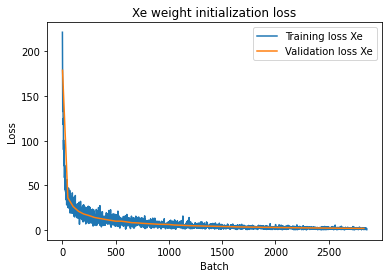

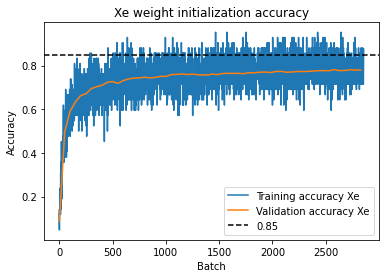

In [ ]:
# Plot training and validation loss for Xe initialization
a, b = zip(*validations_xe)
f1 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(losses_xe, label='Training loss Xe')
ax1.plot(a, b, label='Validation loss Xe')
plt.title('Xe weight initialization loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy for Xe initialization
a, b = zip(*val_accuracies_xe)
f2 = plt.figure()
ax2 = f2.add_subplot(111)
ax2.plot(train_accuracies_xe, label='Training accuracy Xe')
ax2.plot(a, b, label='Validation accuracy Xe')
ax2.axhline(y=0.85, color='black', linestyle='dashed', label='0.85')
plt.title('Xe weight initialization accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# # save the model
# torch.save(model_xe.state_dict(), 'models/model_xe.pt')

In [ ]:
model_orth = ConvNetwork(train_dataset, w_init_method='orthogonal')
model_orth = model_orth.cuda()
objective = CrossEntropyLoss()
optimizer = optim.Adam(model_orth.parameters(), lr=lr)

losses_orth, validations_orth, train_accuracies_orth, val_accuracies_orth = \
    train_model(model_orth, num_epochs, train_loader, optimizer, objective)

In [ ]:
# Plot training and validation loss for Xe initialization
a, b = zip(*validations_orth)
f1 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(losses_orth, label='Training loss orthogonal')
ax1.plot(a, b, label='Validation loss orthogonal')
plt.title('Orthogonal weight initialization loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy for Xe initialization
a, b = zip(*val_accuracies_orth)
f2 = plt.figure()
ax2 = f2.add_subplot(111)
ax2.plot(train_accuracies_orth, label='Training accuracy orthogonal')
ax2.plot(a, b, label='Validation accuracy orthogonal')
ax2.axhline(y=0.85, color='black', linestyle='dashed', label='0.85')
plt.title('Orthogonal weight initialization accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# # save the model
# torch.save(model_orth.state_dict(), 'models/model_orth.pt')

In [ ]:
# Compute and print the number of parameters in the model
model = ConvNetwork(train_dataset)
total = 0
for p in model.parameters():
  size = 1
  for s in p.size():
    size = size * s
  total += size
print (total)

___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **Your answer in bold here**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**

**TODO:**

*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **out_channels=22, kernel_size=(3,3), padding=(2,2)**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **out_channels=65, kernel_size=(3,3), padding(4,4)**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **out_channels=7, kernel_size=(3,3), padding(12,12)**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **out_channels=100, kernel_size=(5,5), padding(4,4)**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **out_channels=23, kernel_size=(5,5), padding(6,6)**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **out_channels=5, kernel_size=(5,5), padding(18,18)**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **out_channels=10, kernel_size=(5,3), padding(1, 0)**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **out_channels=100, kernel_size=(5,3), padding(2, 1)**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **out_channels=23, kernel_size=(5,3), padding(3, 2)**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **out_channels=5, kernel_size=(5,3), padding(9, 8)**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **out_channels=10, kernel_size=(), padding(0,0)**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here** 

**DONE:**


In [ ]:
# Write some test code for checking the answers for these problems (example shown in the video)
